In [1]:
%matplotlib widget
import nest
import numpy as np
import matplotlib.pyplot as plt

import place_field_gen as pfg


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: May 24 2024 10:11:53

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



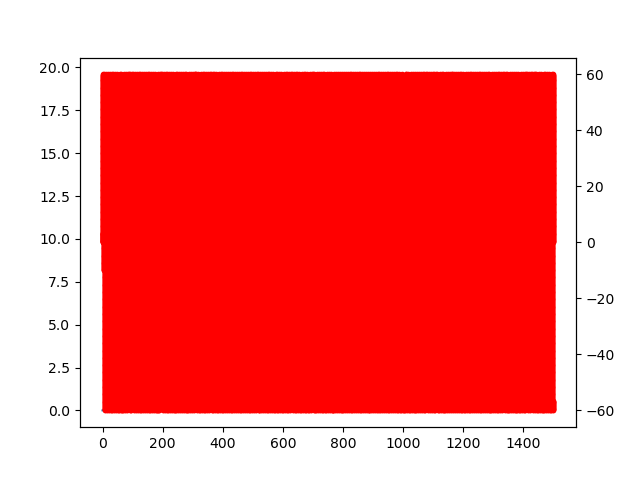

In [7]:
L_maze = 120
maze = pfg.LineMaze(360,L=L_maze)
t,x,y = pfg.gen_traj(maze,500,0.9)
r = pfg.firing_place_cell_linear(t,x,-30,L_maze,7)

plt.close('all')
plt.figure()
plt.plot(t,r(t))
plt.twinx()
plt.plot(t,x,'.r')
plt.show()

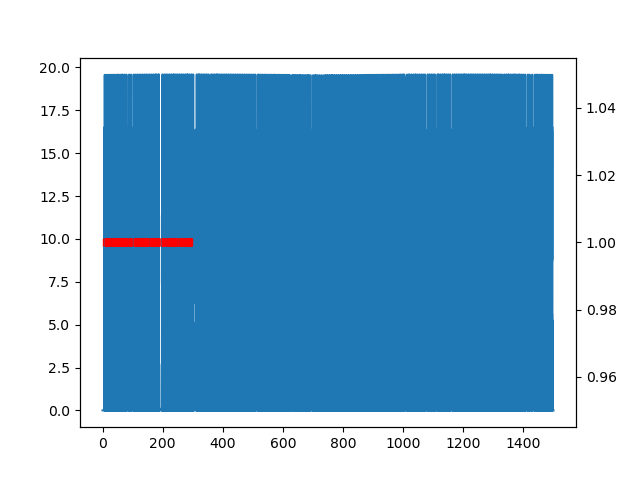

In [8]:
def accept_reject_spike(t0,tmax,r,r_max=20):
    t_spike = []
    t_spike.append(t0)
    t = 0
    while t <= tmax:
        # draw spike at the max rate
        t = t + np.random.exponential(1/r_max)

        # with probability r(t) / r_max, keep the spike
        if np.random.rand() < r(t) / r_max:
            t_spike.append(t0 + t)

    return np.array(t_spike)

s_times = accept_reject_spike(0,300,r)
plt.close('all')
plt.figure()
plt.plot(t,r(t))
plt.twinx()
plt.plot(s_times,np.ones_like(s_times),'|r')
plt.show()

**Exploration phase**

Network properties:
Using the basic structure of the model specified in [1] parameterized as in [2], the cell types in each region are

CA3: 1250 pyr, 100 interneurons

CA1: 1250 pyr, 100 interneurons

Furthermore, 10% of each CA3 and CA1 pyr cells are place cells and will be clamped to place-field like activity during learning, $\lambda_i(t)$. The remaining 90% of cells will be clamped to homogeneous Poisson processes with background rate of 0.1 Hz.

All pyr->pyr connections will be first tuned with STDP as in [1,2]. We accomplish this with NEST's `parrot_neuron` so that we can clamp its firing to a pre-specified spike timing sequence delivered to port 0. The remaining port 1 will be used to recieve spikes that are not repeated, but used in the standard STDP rule. 

Note, since the STDP rule only concerns the spike times of pyr cells, we can ignore both the other cell types AND the neurons' internal dynamics (since its spiking in clamped to a an external driver).

References

[1] Ecker, András, et al. "Hippocampal sharp wave-ripples and the associated sequence replay emerge from structured synaptic interactions in a network model of area CA3." Elife 11 (2022): e71850.

[2] Liu, Can, et al. "Associative and predictive hippocampal codes support memory-guided behaviors." Science 382.6668 (2023): eadi8237.

In [112]:
# Create CA3 and CA1 populations of parrot neurons
nest.ResetKernel()
nest.local_num_threads = 8
t_sim = 240

N_pyr = 1250
CA3_pyr = nest.Create("parrot_neuron", N_pyr)
CA1_pyr = nest.Create("parrot_neuron", N_pyr)
nest.SetStatus(CA3_pyr, {"tau_minus": 62.5})
nest.SetStatus(CA1_pyr, {"tau_minus": 40})

# make the clamped rates to assign to cells
N_generators = int(np.floor(N_pyr*0.1))
place_cell_spikes_CA3 = nest.Create("spike_generator", N_generators)
place_cell_spikes_CA1 = nest.Create("spike_generator", N_generators)

def assign_spikes_to_pf_generator(pf,generator):
    r = pfg.firing_place_cell_linear(t,x,pf,L_maze,7)
    # draw spikes from the rate
    s_times = accept_reject_spike(0,t_sim,r)
    nest.SetStatus(generator, {"spike_times": 1000*s_times+0.1,"allow_offgrid_times": True,"precise_times": False})

    return

# for each generator, draw a random place field on the maze and assign the rate generated
# along a trajectory to the generator
pf_CA3 = np.sort(np.random.uniform(-L_maze/2,L_maze/2,N_generators))
for pf,generator in zip(pf_CA3,place_cell_spikes_CA3):
    assign_spikes_to_pf_generator(pf,generator)

pf_CA1 = np.sort(np.random.uniform(-L_maze/2,L_maze/2,N_generators))
for pf,generator in zip(pf_CA1,place_cell_spikes_CA1):
    assign_spikes_to_pf_generator(pf,generator)

# generate the rest of the generators with random rates
silent_cell_spikes = nest.Create("poisson_generator")
nest.SetStatus(silent_cell_spikes, {"rate": 0.1})

# connect the generators to the CA3 and CA1 populations
nest.Connect(place_cell_spikes_CA3, CA3_pyr[0:N_generators], syn_spec={'weight': 1.0}, conn_spec={'rule': 'one_to_one'})
nest.Connect(silent_cell_spikes, CA3_pyr[N_generators:], syn_spec={'weight': 1.0}, conn_spec={'rule': 'all_to_all'})
nest.Connect(place_cell_spikes_CA1, CA1_pyr[0:N_generators], syn_spec={'weight': 1.0}, conn_spec={'rule': 'one_to_one'})
nest.Connect(silent_cell_spikes, CA1_pyr[N_generators:], syn_spec={'weight': 1.0}, conn_spec={'rule': 'all_to_all'})

# define a STDP synapse
weight_recorder = nest.Create("weight_recorder")
nest.CopyModel("stdp_synapse", "CA3_to_CA3",{"alpha": -1.0, "lambda": 0.08, "tau_plus": 62.5, "weight": 0.3,"mu_plus":0,"mu_minus":0, "Wmax": 20.0,"weight_recorder": weight_recorder})
nest.CopyModel("stdp_synapse", "CA3_to_CA1",{"alpha": 0.4, "lambda": 0.04, "tau_plus": 20.0, "weight": 0.7,"mu_plus":0,"mu_minus":0, "Wmax": 20.0,"weight_recorder": weight_recorder})

# connect the CA3 and CA1 populations with the STDP synapse
nest.Connect(CA3_pyr, CA3_pyr, syn_spec={'synapse_model':"CA3_to_CA3",'receptor_type':1}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.1})
nest.Connect(CA3_pyr, CA1_pyr, syn_spec={'synapse_model':"CA3_to_CA1",'receptor_type':1}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.1})

# monitor the spiking activity of the CA3 and CA1 populations
spike_detector = nest.Create("spike_recorder")
nest.Connect(CA3_pyr, spike_detector)
nest.Connect(CA1_pyr, spike_detector)
nest.Simulate(t_sim*1000)


Jul 25 19:55:03 NodeManager::prepare_nodes [Info]: 
    Preparing 4524 nodes for simulation.

Jul 25 19:55:03 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 4524
    Simulation time (ms): 240000
    Number of OpenMP threads: 8
    Not using MPI

Jul 25 19:55:26 SimulationManager::run [Info]: 
    Simulation finished.


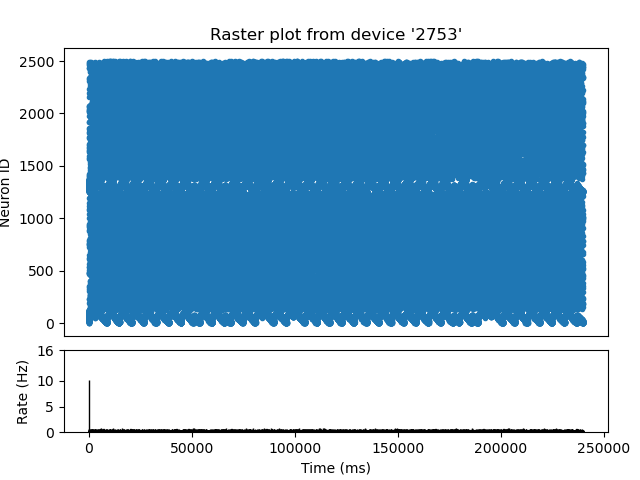

In [113]:
from nest import raster_plot

plt.close('all')
raster_plot.from_device(spike_detector,hist=True, hist_binwidth=10.0)

**Post-exploration** 

Now that the pyramidal cell weight matrix has been tuned, we can "query" its spontaneous activity by using it in a network driven by noise.

In [114]:
conn_CA3_to_CA3 = nest.GetConnections(CA3_pyr,CA3_pyr).get(['source','target','weight'])
conn_CA3_to_CA1 = nest.GetConnections(CA3_pyr,CA1_pyr).get(['source','target','weight'])

In [129]:
# making a new newtork
nest.ResetKernel()
nest.SetKernelStatus({"resolution": 0.1})

# Create CA3 and CA1 populations of adaptive exponential integrate-and-fire neurons
N_pyr = 1250
pyr_spec = {'C_m':180,'g_L':4.3,'E_L':-75,'Delta_T':4.23,'V_th':-24,'V_peak':-3.25,'V_reset':-29.7,'t_ref':5.9,'tau_w':84.93,'a':-0.27,'b':206.84,'E_rev':[0,-90],'tau_rise':[1,0.3],'tau_decay':[5,3]}
CA3_pyr_aeif = nest.Create("aeif_cond_beta_multisynapse", N_pyr, pyr_spec)
CA1_pyr_aeif = nest.Create("aeif_cond_beta_multisynapse", N_pyr, pyr_spec)
# make interneurons in CA3 and CA1
N_int = 250
int_spec = {'C_m':118,'g_L':7.5,'E_L':-74,'Delta_T':4.6,'V_th':-57.7,'V_peak':-34.78,'V_reset':-65,'t_ref':1,'tau_w':178.58,'a':3.05,'b':0.91,'E_rev':[0,-90],'tau_rise':[1,0.3],'tau_decay':[5,3]}
CA3_int_aeif = nest.Create("aeif_cond_beta_multisynapse", N_int, int_spec)
CA1_int_aeif = nest.Create("aeif_cond_beta_multisynapse", N_int, int_spec)

# connect the CA3 and CA1 populations with static synapses with the weights learned from the previous simulation
# the order of nodes is presevered since the neurons are created in the same order
nest.Connect(conn_CA3_to_CA3['source'], conn_CA3_to_CA3['target'], 'one_to_one', syn_spec={'synapse_model':'static_synapse','weight': conn_CA3_to_CA3['weight'], 'receptor_type':1})
nest.Connect(conn_CA3_to_CA1['source'], conn_CA3_to_CA1['target'], 'one_to_one', syn_spec={'synapse_model':'static_synapse','weight': conn_CA3_to_CA1['weight'], 'receptor_type':1})

# now we wire pyr to int with a probability of 0.1
nest.Connect(CA3_pyr_aeif, CA3_int_aeif, syn_spec={'weight': 0.85, 'receptor_type':1}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.1})
nest.Connect(CA1_pyr_aeif, CA1_int_aeif, syn_spec={'weight': 0.85, 'receptor_type':1}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.1})

# connect the interneurons with each other with a probability of 0.25
nest.Connect(CA3_int_aeif, CA3_int_aeif, syn_spec={'weight': 5, 'receptor_type':2}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.25})
nest.Connect(CA1_int_aeif, CA1_int_aeif, syn_spec={'weight': 5, 'receptor_type':2}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.25})

# and the interneurons to the pyramidal cells with a probability of 0.25
nest.Connect(CA3_int_aeif, CA3_pyr_aeif, syn_spec={'weight': 0.65, 'receptor_type':2}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.25})
nest.Connect(CA1_int_aeif, CA1_pyr_aeif, syn_spec={'weight': 0.65, 'receptor_type':2}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.25})

# create a stim to drive all the CA3 pyramidal cells
stim = nest.Create("poisson_generator",1,{'rate': 15.0})
nest.Connect(stim, CA3_pyr_aeif, syn_spec={'weight': 15.0, 'receptor_type':1}, conn_spec={'rule': 'all_to_all'})

# monitor the spiking activity of the CA3 and CA1 populations
spike_detector = nest.Create("spike_recorder")
nest.Connect(CA3_pyr_aeif, spike_detector)
#nest.Connect(CA1_pyr_aeif, spike_detector)
#nest.Connect(CA3_int_aeif, spike_detector)
#nest.Connect(CA1_int_aeif, spike_detector)
nest.Simulate(5000)


Jul 25 20:06:57 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 25 20:06:57 NodeManager::prepare_nodes [Info]: 
    Preparing 3002 nodes for simulation.

Jul 25 20:06:57 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3002
    Simulation time (ms): 5000
    Number of OpenMP threads: 1
    Not using MPI

Jul 25 20:07:38 SimulationManager::run [Info]: 
    Simulation finished.


In [130]:
plt.close('all')
raster_plot.from_device(spike_detector,hist=False)
plt.ylim([0,125])

NESTError: No events recorded!